# Preparing the environment for EDA

In [1]:
# Imports of Models & libraries. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import nltk
import os
import string   
import re
import squarify
import math

from pywaffle import Waffle
from datetime import datetime
from statsmodels.formula.api import ols
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.validation import column_or_1d
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from textblob import TextBlob
from scipy.stats import norm
from collections import Counter
from nltk import PorterStemmer
from scipy.ndimage import gaussian_gradient_magnitude
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data
central_london = pd.read_csv('Central_London.csv')

In [3]:
# View Metadata
central_london.info()
# 758,162 rows of data with top row for headers
# Some un-named columns, need to explore what they contain

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048366 entries, 0 to 1048365
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Survey wave (calendar quarter)  758163 non-null  object 
 1   Equivalent financial quarter    758163 non-null  object 
 2   Site ID                         758163 non-null  object 
 3   Location                        758163 non-null  object 
 4   Survey date                     748007 non-null  object 
 5   Weather                         746329 non-null  object 
 6   Time                            758163 non-null  object 
 7   Period                          758163 non-null  object 
 8   Direction                       758163 non-null  object 
 9   Start hour                      758163 non-null  float64
 10  Start minute                    758163 non-null  float64
 11  Number of private cycles        758099 non-null  float64
 12  Number of cycl

In [4]:
# Look at random sample of data
central_london.sample(5)

,Survey wave (calendar quarter),Equivalent financial quarter,Site ID,Location,Survey date,Weather,Time,Period,Direction,Start hour,Start minute,Number of private cycles,Number of cycle hire bikes,Total cycles,Unnamed: 14,Unnamed: 15,Unnamed: 16
29566,2014 Q2 (April-June),2014-15 Q1,CENCY033,Bermondsey Street,"jeu, 24/04/14",Dry,2130 - 2145,Evening (19:00-22:00),Northbound,21.0,30.0,0.0,0.0,0.0,NaN,NaN,NaN
100444,2014 Q4 (October-December),2014-15 Q3,CENCY186,Montagu Place,"ven, 12/12/14",Cloudy,1300 - 1315,Inter-peak (10:00-16:00),Eastbound,13.0,0.0,1.0,1.0,2.0,NaN,NaN,NaN
1029497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
716982,2021 Q3 (July-September),2021-22 Q2,CENCY097,Crucifix Lane (Druid Street),"jeu, 16/09/21",Dry,2045 - 2100,Evening (19:00-22:00),Westbound,20.0,45.0,4.0,0.0,4.0,NaN,NaN,NaN
830912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Wrangling

In [5]:
# Drop empty columns
central_london.dropna(how='all', axis=1, inplace=True)
# Drop empty rows
central_london.dropna(how='all')

,Survey wave (calendar quarter),Equivalent financial quarter,Site ID,Location,Survey date,Weather,Time,Period,Direction,Start hour,Start minute,Number of private cycles,Number of cycle hire bikes,Total cycles
0,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),"ven, 24/01/14",Dry,0600 - 0615,Early Morning (06:00-07:00),Northbound,6.0,0.0,0.0,0.0,0.0
1,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),"ven, 24/01/14",Dry,0615 - 0630,Early Morning (06:00-07:00),Northbound,6.0,15.0,15.0,0.0,15.0
2,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),"ven, 24/01/14",Dry,0630 - 0645,Early Morning (06:00-07:00),Northbound,6.0,30.0,35.0,0.0,35.0
3,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),"ven, 24/01/14",Dry,0645 - 0700,Early Morning (06:00-07:00),Northbound,6.0,45.0,59.0,2.0,61.0
4,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),"ven, 24/01/14",Dry,0700 - 0715,AM peak (07:00-10:00),Northbound,7.0,0.0,73.0,0.0,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758158,2021 Q4 (October-December),2021-22 Q3,CENCY702,Haymarket,"mar, 21/12/21",Dry,2045 - 2100,Evening (19:00-22:00),Southbound,20.0,45.0,22.0,1.0,23.0
758159,2021 Q4 (October-December),2021-22 Q3,CENCY702,Haymarket,"mar, 21/12/21",Dry,2100 - 2115,Evening (19:00-22:00),Southbound,21.0,0.0,20.0,0.0,20.0
758160,2021 Q4 (October-December),2021-22 Q3,CENCY702,Haymarket,"mar, 21/12/21",Dry,2115 - 2130,Evening (19:00-22:00),Southbound,21.0,15.0,16.0,1.0,17.0
758161,2021 Q4 (October-December),2021-22 Q3,CENCY702,Haymarket,"mar, 21/12/21",Dry,2130 - 2145,Evening (19:00-22:00),Southbound,21.0,30.0,10.0,1.0,11.0


In [6]:
# Rename columns to remove space in column names
central_london.columns = central_london.columns.str.replace(' ','_')

In [7]:
# Parse Dates correctly
# Remove French Day name in Survey Date 
central_london["Survey_date"] = central_london["Survey_date"].str.replace(r'\D+', '', regex=True)

# Convert to datetime format
central_london['Survey_date'] = pd.to_datetime(central_london.Survey_date)

# Sort DataFrame by chronological order
central_london = central_london.sort_values(['Survey_date', 'Start_hour', 'Start_minute'])

# Replace with value of previous value row where there is a missing value in Survey_date
central_london['Survey_date'].fillna(method='ffill', inplace=True)

# Define day of the week in English and add back as a column
central_london['Day_of_week'] = central_london['Survey_date'].dt.day_name()

# Pass Month into a new column
central_london['month'] = central_london['Survey_date'].dt.month

In [8]:
# Pass Season
# Create function for user defined seasons
def f(x):
    if (x >= 1) and (x <= 2):
        return 'Winter'
    elif (x > 2) and (x <= 5 ):
        return 'Spring'
    elif (x > 5) and (x <= 8):
        return'Summer'
    elif (x > 8) and (x <= 11) :
        return 'Autumn'
    elif (x > 11):
        return'Winter'

# Apply user defined function to create new column with seasons
central_london['season'] = central_london['month'].apply(f)

In [9]:
# Check missing values
central_london.isnull().sum()

# Relatively large number. 
# Drop the ones without survey date.

Survey_wave_(calendar_quarter)    290203
Equivalent_financial_quarter      290203
Site_ID                           290203
Location                          290203
Survey_date                            0
Weather                           302037
Time                              290203
Period                            290203
Direction                         290203
Start_hour                        290203
Start_minute                      290203
Number_of_private_cycles          290267
Number_of_cycle_hire_bikes        290267
Total_cycles                      290203
Day_of_week                            0
month                                  0
season                                 0
dtype: int64

In [10]:
# We see time not recorded. Given how small the effected sample size is we remove them.
central_london = central_london.dropna(subset=['Time'])

In [11]:
# Recheck output
central_london.isnull().sum()

# Just Weather data missing which can be reclassified as Unknown later
# Few more missing values in type of cycles ownership. Will retain for now and revist.

Survey_wave_(calendar_quarter)        0
Equivalent_financial_quarter          0
Site_ID                               0
Location                              0
Survey_date                           0
Weather                           11834
Time                                  0
Period                                0
Direction                             0
Start_hour                            0
Start_minute                          0
Number_of_private_cycles             64
Number_of_cycle_hire_bikes           64
Total_cycles                          0
Day_of_week                           0
month                                 0
season                                0
dtype: int64

In [12]:
# View Metadata now
central_london.info()
# All data successfully cleaned/maintained.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 758163 entries, 27328 to 678591
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Survey_wave_(calendar_quarter)  758163 non-null  object        
 1   Equivalent_financial_quarter    758163 non-null  object        
 2   Site_ID                         758163 non-null  object        
 3   Location                        758163 non-null  object        
 4   Survey_date                     758163 non-null  datetime64[ns]
 5   Weather                         746329 non-null  object        
 6   Time                            758163 non-null  object        
 7   Period                          758163 non-null  object        
 8   Direction                       758163 non-null  object        
 9   Start_hour                      758163 non-null  float64       
 10  Start_minute                    758163 non-null  flo

In [13]:
# Drop rows where total cycles doesnt add up to number of private and hire cycles.
# Creating a column to add up the values
central_london['Sum'] = central_london['Number_of_private_cycles'] + central_london['Number_of_cycle_hire_bikes']

# Dropping rows where the column values dont add up 
central_london = central_london[central_london.Total_cycles == central_london.Sum]

# Look at output
central_london.info()

# 64 rows dropped where total cycles doesnt add up with its constituent parts.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 758099 entries, 27328 to 678591
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Survey_wave_(calendar_quarter)  758099 non-null  object        
 1   Equivalent_financial_quarter    758099 non-null  object        
 2   Site_ID                         758099 non-null  object        
 3   Location                        758099 non-null  object        
 4   Survey_date                     758099 non-null  datetime64[ns]
 5   Weather                         746265 non-null  object        
 6   Time                            758099 non-null  object        
 7   Period                          758099 non-null  object        
 8   Direction                       758099 non-null  object        
 9   Start_hour                      758099 non-null  float64       
 10  Start_minute                    758099 non-null  flo

In [14]:
# Drop the redundant columns to reduce size of dataFrame & memomry consumption
central_london.drop(['Sum', 'Start_hour', 'Start_minute', 'month', 'Equivalent_financial_quarter'], axis=1)

,Survey_wave_(calendar_quarter),Site_ID,Location,Survey_date,Weather,Time,Period,Direction,Number_of_private_cycles,Number_of_cycle_hire_bikes,Total_cycles,Day_of_week,season
27328,2014 Q2 (April-June),CENCY016,Lambeth Bridge,2014-01-04,Dry,0600 - 0615,Early Morning (06:00-07:00),Eastbound,4.0,0.0,4.0,Saturday,Winter
27392,2014 Q2 (April-June),CENCY016,Lambeth Bridge,2014-01-04,Dry,0600 - 0615,Early Morning (06:00-07:00),Westbound,6.0,1.0,7.0,Saturday,Winter
32064,2014 Q2 (April-June),CENCY053,City Road,2014-01-04,Dry,0600 - 0615,Early Morning (06:00-07:00),Northbound,4.0,1.0,5.0,Saturday,Winter
32128,2014 Q2 (April-June),CENCY053,City Road,2014-01-04,Dry,0600 - 0615,Early Morning (06:00-07:00),Southbound,3.0,2.0,5.0,Saturday,Winter
40000,2014 Q2 (April-June),CENCY116,George Street (east),2014-01-04,Dry,0600 - 0615,Early Morning (06:00-07:00),Eastbound,4.0,0.0,4.0,Saturday,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...
664255,2020 Q3 (July-September),CENCY084,Southwark Street,2021-12-30,Wet,2145 - 2200,Evening (19:00-22:00),Westbound,6.0,3.0,9.0,Thursday,Winter
673919,2020 Q3 (July-September),CENCY160,Old Compton Street,2021-12-30,NaN,2145 - 2200,Evening (19:00-22:00),Eastbound,0.0,0.0,0.0,Thursday,Winter
673983,2020 Q3 (July-September),CENCY160,Old Compton Street,2021-12-30,NaN,2145 - 2200,Evening (19:00-22:00),Westbound,0.0,0.0,0.0,Thursday,Winter
678527,2020 Q3 (July-September),CENCY196,Poland Street,2021-12-30,NaN,2145 - 2200,Evening (19:00-22:00),Northbound,0.0,0.0,0.0,Thursday,Winter


In [15]:
# Drop the additional information in Survey wave column 
# alligns with the way this info is presented in the other London datasets.
central_london["Survey_wave_(calendar_quarter)"] = central_london["Survey_wave_(calendar_quarter)"].str.replace(r'\D+', '', regex=True)

# Drop the last number in every row 
central_london['Survey_wave_(calendar_quarter)'] = central_london['Survey_wave_(calendar_quarter)'].astype(str).str[:-1].astype(np.int64)

# Rename Column Name to align with other London Datasets
central_london.rename(columns={'Survey_wave_(calendar_quarter)': 'Survey_wave_(year)'}, inplace = True)

In [16]:
central_london.sample(5)

,Survey_wave_(year),Equivalent_financial_quarter,Site_ID,Location,Survey_date,Weather,Time,Period,Direction,Start_hour,Start_minute,Number_of_private_cycles,Number_of_cycle_hire_bikes,Total_cycles,Day_of_week,month,season,Sum
452379,2018,2018-19 Q1,CENCY107,Beech Street,2018-04-05,Dry,1245 - 1300,Inter-peak (10:00-16:00),Westbound,12.0,45.0,11.0,2.0,13.0,Thursday,4,Spring,13.0
598982,2019,2019-20 Q2,CENCY204,St. George's Road,2019-07-16,Dry,0730 - 0745,AM peak (07:00-10:00),Northbound,7.0,30.0,57.0,1.0,58.0,Tuesday,7,Summer,58.0
506736,2018,2018-19 Q3,CENCY112,Grosvenor Street,2018-11-14,Fine,1800 - 1815,PM peak (16:00-19:00),Eastbound,18.0,0.0,0.0,0.0,0.0,Wednesday,11,Autumn,0.0
147230,2015,2015-16 Q1,CENCY149,Upper Ground,2015-04-21,Dry,1330 - 1345,Inter-peak (10:00-16:00),Westbound,13.0,30.0,16.0,3.0,19.0,Tuesday,4,Spring,19.0
18603,2014,2013-14 Q4,CENCY149,Upper Ground,2014-04-02,Wet,1645 - 1700,PM peak (16:00-19:00),Eastbound,16.0,45.0,10.0,1.0,11.0,Wednesday,4,Spring,11.0


In [17]:
# Count unique values in each column
for col in central_london:
  print(col,": ", central_london[col].nunique())

# More site ids vs location again.
# May imply multiple sites in same location. Does this double count? Need to check!
# Survey period of 8 years
# 5 Periods of day which should be synched in same fashion with all the other city count data
# will use london period of day definition as base.
# 282 types of weather needs to be discussed and trimmed with team

Survey_wave_(year) :  8
Equivalent_financial_quarter :  29
Site_ID :  210
Location :  205
Survey_date :  1596
Weather :  283
Time :  64
Period :  5
Direction :  4
Start_hour :  16
Start_minute :  4
Number_of_private_cycles :  435
Number_of_cycle_hire_bikes :  87
Total_cycles :  479
Day_of_week :  7
month :  12
season :  4
Sum :  479


In [18]:
# Explore the different types of Weather
print(central_london.Weather.unique())

# Lots of overlaps for e.g. Rain & Wet, Dry/cold and dry Cold.
# Need to classify into much narrower streams. 

['Dry' 'Damp' 'Fine' 'Wet' nan 'Cloudy' 'Cold/rain' 'Rain' 'Light Rain'
 'Slightly Wet' 'Rain Dry' 'Wet Damp' 'Rain Damp' 'Rain Stopped'
 'Road Wet' 'Almost Dry' 'Showery' 'Very Wet' 'Cloudy/rain' 'Wet - Dry'
 'S. Wet' 'V. Wet' 'Dry - Wet' 'Cold/ Rain' 'Foggy' 'Dull' 'Sun' 'Drizzle'
 'Dry/wet' 'Wet Intermittently' 'Hazy' 'Lt Rain' 'Dry & Sunny' 'Shower'
 'Showers' 'Rainy' 'Spitting' 'Wet/dry' 'Wet/ Dry' 'Fair' 'Wet Road'
 'Sunny' 'Blustery' 'Cold' 'Down Pour' 'Dry & Very Windy' 'Partly Cloudy'
 'Kdry' 'Light Showers' 'V Wet' 'Mild' 'Dry & Wet' 'Rain/wind' 'Deluge'
 'Dry - Rain' 'Light Shower' 'Damp - Rain' 'Slight Drizzle'
 'Very Heavy Rain' 'Wet & Windy' 'Windy' 'Dry A.m Wet P.m' 'Wet + Windy'
 'Fine Windy' 'Dry Windy' 'Cloudy/ Rain' 'Wet T' 'V Light Rain'
 'Windy/ Rain' 'Dry Wet Road' 'Mist' 'Dry Wed' 'Wetr' 'Drty'
 'Cold Windy Dry' 'Dry Thu' 'Showers Mix' 'Road Drying Sun Out' 'Dryish'
 'Dry Fri' 'D' 'Dark Sunny' 'Dark Dry' 'Dark' 'Rains' 'Sunny Cloudy'
 'Dry Dark' 'Light Shrs' 'Som

In [19]:
# Replace some obvious duplications in Weather
# Rain
central_london['Weather'] = central_london['Weather'].replace(['Wet','Cloudy/rain','Rain','Mix Wet/dry','Drizzle',
                                                          'Light Showers', 'Mizzle','Windy/rain','Showers',
                                                          'Wet/dry','Wet/damp','Shower','Drizzle/shower','Rainy',
                                                          'wet','Cloudy with showers','Generally overcast brief shower'
                                                          'Light Rain','Shower/dry','Spitting','Drizzle/cloudy',
                                                          'Dry/wet','Damp', 'Dry/drizzle','Dull/damp','Dry-wet',
                                                          'Wet/mix', 'Drizzle/wet','Wet/windy','Rain Shower',
                                                          'Intermittent Showers','Cloudy/drizzle','Rain/drizzle',
                                                          'Wet Road','Drizzle/dry','Drizzle/rain','Mixed Sunny + Rain',
                                                          'Wet/rain', 'V Light Drizzle', 'Rainy', 'W','Slight Drizzle',
                                                          'Rain Stopped', 'Stopped Raining','Wet Rain Stopped','Raining/wet',
                                                          'Showery','Overcast/rain','Rain/wet','Rain/showers','Showers/sunny',
                                                          'Drizzle/showers','Wet/stop Raining','Drizzle Rain','Drizzle Wet',
                                                          'Damp/sun','Raining','Dry + Wet','Showers/cloudy','Cloudy/showers',
                                                          'Getting Wet','Wet Road:sun','Dry But Wet Road','Drizze',
                                                          'wet','Wettish','Light Rain','S.wet','S/w','Cold/rain',
                                                           'Slightly Wet','Road Wet','Light Shower','Rain Damp','Wet Damp',
                                                              'Wet - Dry','Dry - Wet','Rain Dry','Dry - Rain','Damp - Rain',
                                                              'Wet/ Dry','S. Wet','Cloudy/ Rain','Windy/ Rain','Wet T',
                                                              'Some Showers','Rains','Sunny/rainy','Wetr','Showers Mix',
                                                              'Rain/dry','Rain/cloudy','Shower/wet','Wetter',
                                                              'Heavy Rain','Heavy Shower','Heavy Shr','Down Pour',
                                                           'Deluge','Heavy Showers', 'Shower','Rain Heavy Showers',
                                                           'Intermitent Showers','Thunder Lightening Rain!','Very Wet',
                                                           'V.wet','Heavy Downpour/rain','Showery','Wet Heavy Rain',
                                                           'Wet (heavy Rain)','Wet (shower)','Blustery','V. Wet',
                                                              'Rain & Thunder','Rain-heavy','H Rain','Wert','(rain After)',
                                                              'Cloud/rain','Really Wet','Periods Of Rain Quite Windy',
                                                              'Steady Rain'],'Rain')

# Good
central_london['Weather'] = central_london['Weather'].replace(['Sunny','Cloudy Sunny','Sun Setting','Good','Dry/sunny',
                                                          'Fine + Dry', 'Fine + Hot','Bright','Dry Hot!!',
                                                          'Dry & Sunny','Dry & Sun','Fine & Dry','Good/dry','Sun',
                                                          'Sunny Dry','Clear and Bright', 'Fine', 'Dry/good', 
                                                          'Fine/dry', 'Warm + Dry','Dry','Dry                         9',
                                                          'Sunny','Cloudy/sunny','Druy','Dry/hot','Dry Warm',
                                                          'Dry/sun','Dryish','Clear And Dry','Clear and Dry','Dry, Warm',
                                                          'Dry, Sunny, Warm','Cloudy with Clear Intervals','Clear and Warm',
                                                          'Dry But Misty','Sunny & Warm All Day','Clear','Dry + Sunny',
                                                          'Sunny/dry','Dr Ry','Dry Y','D','Warm/dry','Bright/dry','Dry Sunny',
                                                          'Fair','Dry/sun','Kdry','Fine Windy',
                                                               'Cloudy','Sunny Overcast Sunny','Sunny/cloudy',
                                                               'Cloudy/rain/sunny','Cloudy + Sunny','Sunny + Cloudy',
                                                               'Cloudy/sunny','Bright + Cloudy','Cloudy/dry',
                                                               'Partly Sunny','Dull','Dry & Mild','Cloud','Overcast',
                                                               'Mild','Overcast (No Rain)','Cloudy bright intervals',
                                                               'Generally overcast','Cloudy with clear spells',
                                                               'Sunny Overcast','Dry','Dry/mild', 'Clear',
                                                               'Cloudy and Dry','Partly cloudy but dry',
                                                          'Partly cloudy and dry','Cloudy but dry','Partly cloudy and Dry',
                                                          'Sun/Cloudy','Clouds & Sunny','Sun/clouds','Cloudy & Sunny',
                                                          'Sun & Clouds','Cloudy Dry','Cloud/sun','Mixed','Sun/cloud',
                                                           'Sunny/cloudy','Cloudy Sun','Cloudy/sun','Dry/cloudy',
                                                           'Sun/cloudy','Overcast/dry','Cloud','Dull','Dry/overcast',
                                                          'Dark/cloudy','Cloudy/dry','Cloudy','Hazy','Partly Cloudy',
                                                               'Drty','Dry (windy)','Fine (windy)','Sunny Cloudy',
                                                              'Dry Dark','Dark','Dry Mon','Dry Wed','Dry Thu','Dry Fri',
                                                              'Sun/rain','Thunder','Cloudy','Sunny Overcast Sunny',
                                                               'Sunny/cloudy','Cloudy/rain/sunny',
                                                           'Cloudy + Sunny','Sunny + Cloudy', 'Cloudy/sunny',
                                                           'Bright + Cloudy','Cloudy/dry','Partly Sunny','Dull','Dry & Mild',
                                                           'Cloud','Overcast','Mild','Overcast (No Rain)',
                                                          'Cloudy bright intervals','Generally overcast',
                                                           'Cloudy with clear spells','Sunny Overcast','Dry',
                                                           'Dry/mild', 'Clear','Cloudy and Dry','Partly cloudy but dry',
                                                          'Partly cloudy and dry','Cloudy but dry','Partly cloudy and Dry',
                                                          'Sun/Cloudy','Clouds & Sunny','Sun/clouds','Cloudy & Sunny',
                                                          'Sun & Clouds','Cloudy Dry','Cloud/sun','Mixed','Sun/cloud',
                                                           'Sunny/cloudy','Cloudy Sun','Cloudy/sun','Dry/cloudy',
                                                           'Sun/cloudy','Overcast/dry','Cloud','Dull','Dry/overcast',
                                                          'Dark/cloudy','Cloudy/dry','Cloudy','Hazy','Partly Cloudy',
                                                               'Drty','Dry (windy)','Fine (windy)','Sunny Cloudy',
                                                              'Dry Dark','Dark','Dry Mon','Dry Wed','Dry Thu','Dry Fri',
                                                              'Sun/rain','Thunder','Ddry','Dy','Dry/sunny/cold','Fine Cold',
                                                              'Cold Dry','Dry & Cold','Dry And Fine','Dry And Sunny',
                                                              'Dry And Warm','Fine And Dry','Warm + Sunny','Warm And Humid',
                                                              'Warm And Windy','Overcast And Dull','Cloudy And Warm',
                                                              'Sunny Periods And Warm','Dry And Windy','Dry And Very Windy',
                                                              'Warm Sunny And Windy','Hot And Humid','Mild And Sunny',
                                                               'Warm And Overcast','Sunny & Windy','Windy/cloudy',
                                                              'Dry/gusty','Coldish','Windy/dry','Dry But A Bit Windy',
                                                               'Sunny Cold','Cold At First Then Warm/sunny',
                                                              'Warm & Sunny Chilly Later','Fine + Dry Chilly At First',
                                                               'Fine & Sunny','dry','A Bit Chilly At First',
                                                               'Warm With A Slight Wind','Cold Then Dry And Windy',
                                                               'Dry And Overcast','Warm + Sunny Cloudy + Windy',
                                                              'Dry 3/4 Dry','Sunny Until Evening But Windy',
                                                               'Winds Rather Chilly','Warm','Sunny But Very Windy',
                                                               'Now Starts To Get Chilly'],'Good')


# Light Rain
central_london['Weather'] = central_london['Weather'].replace(['Wet/dry','Intermittent Light Drizzle','Light Rain',
                                                           'Lt Rain','Drizzle','Intermittent Drizzle', 'Damp','Getting Dry',
                                                           'Dry & Wet','Slight Drizzle/dry','Wet Intermittently',
                                                               'Light Rain','V Light Rain','Dry Wet Road','Dry A.m Wet P.m',
                                                               'Mist','Road Drying Sun Out','Wetish','Light Shrs',
                                                              'Fine Drizzle','V Light Shrs','L/rain','Rain Stopped-dry',
                                                              'V Lt Rain','V.light Rain','Dry (+brief Speels Of Drizzle',
                                                              'Wet (spitting)','Drizzly Rain','Almost Dry','Damp & Drizzly',
                                                              'Dry Road Wet With Leaves','Wet Drizzle','No Rain Wet Roads',
                                                              'Dry But Wet Roads','Very Light Rain','Light Drizzle',
                                                              'Dry/wet Road Surface','V Light Showers','V. Light Rain',
                                                              'Wet/cloudy','Wet/sunny','Dry Road Still Wet',
                                                              '2 Snowflakes Otherwise Dry','Wet-dry','Dry/drizzly',
                                                              'Wet/light Showers','Wet/drizzle','Wet And Windy',
                                                              'Drizzling','Drizzle Damp','Windy Showery','Wet + Dry',
                                                              'V.light Drizzle','Very Light Drizzle','Drying Up','Wet Again',
                                                              'Cold Sunny Rain','Wet First Then Dry','Wetr First Then Dry',
                                                              'Dry With Intermitent Rain','(drizzle)','Damp/misty/wet',
                                                              'Dry But Rain Threatening','Slight Drizzle Till End',
                                                              'Damp/misty','Cold & Dry Early Rain Later',
                                                              'Wet ','Windy/drizzle','Intermitent Light Showers',
                                                              'Intermitent Light Rain','A Few Rain Showers','Drizzly',
                                                              'Rain Looking Likely','A Few Drops Of Rain'],'Damp')

# Dangerous Weather
central_london['Weather'] = central_london['Weather'].replace(['Heavy Rain','Dry/wet Road','Dry With Wet Road',
                                                           'Hot','Snow!','Snow', 'Sleet','Very Hot',
                                                           'Dry (road Wet)','Dry, Sunny, Hot','Very Heavy Rain',
                                                           'Intermittent Heavy Showers','Very Hot/dry','Hot/dry',
                                                           'Storm','Heavy Rain High Winds','V Wet','Rain Heavy',
                                                          'Sunny (hot!)','Heavy Thunder','Overcast/rain Heavy Showers',
                                                          'Too Cold','High Wind','Very Windy','Dry & Very Windy',
                                                              'Very Hot Dry','Wet/windy','Wet/v.windy','Wet Hail',
                                                               'Rain/hail','Foggy Wet',
                                                           'Wet Heavy Wind', 'Wet-windy','Hailstones',
                                                           'Short Hail Shower','Rain/sleet','Hail Stone',
                                                          'Hail','Showers/hailstone','Rain/hailstone','Cold/ Rain',
                                                              'Foggy','Wet & Windy','Wet + Windy','Rain/wind',
                                                              'Wet (windy)','Occasional Lt Snow Shrs',
                                                              'Wet And Very Windy','Dry Chill','Dry/cold','Dry Cold',
                                                               'Cold/sunny','Cold/cloudy',
                                                           'Dry Very Windy', 'Dry/windy','Windy','Cold','Cloudy/windy',
                                                           'Windy + Sunny','Sunsetting + Windy','Dark Cloudy',
                                                           'Dry V. Cold!','Very Cool','Dry & Windy',
                                                          'Dry but Cold or Wind','Dry/v. Windy','Dry Windy',
                                                          'Windy At First Then Sunny','Windy Dry','Cold Windy Dry',
                                                              'Cold/dry','Some Heavy Showers','Very Cold/dry',
                                                              'Foggy/v Cold','Hail Shower','Snowing','Wet/ Snowing',
                                                              'Heavy Snow','Dry/very Windy','Very Windy & Cold',
                                                              'Wet Light Hailstone','Heavy Showers Throughout Day',
                                                              'High Winds & Spits Of Rain','Fine V Cold',
                                                              'Dry (frost & Fog)','V Cold Showers','Cold/showery',
                                                              'Light Showers Inc Some Hail','Cloudy/hail','Cold Wind',
                                                              'Hot & Sunny','Hot And Sunny','Dry/windy/strong Wind',
                                                              'Hot + Humid','Very Cold Sunny But Windy'],'Dangerous_Conditions')

# Consolidating 'Unknown'
central_london['Weather'] = central_london['Weather'].replace(['School Out','N/a','Unknown','Dark Sunny',
                                                              'Wed','Warm & Sunny But Windy & Cold'],'Unknown')

# Transforming Nan Values into Unknown
# Replacing nan with 'Unknown'
central_london.Weather = central_london.Weather.fillna('Unknown')

# Consolidating "Dry Dark"
central_london['Weather'] = central_london['Weather'].replace(['Dry Dark','Dry/dark','Dark/dry',
                                                           'Dark Dry', 'X'],'Unknown')

In [20]:
# Check output
print(central_london.Weather.unique())

# Aligns with the rest of London Data now.

['Good' 'Rain' 'Unknown' 'Damp' 'Dangerous_Conditions']


# Basic Visualisations

## How has cycling evolved over time?

In [21]:
# Aggregate data by survey year
df= central_london.groupby(['Survey_wave_(year)'], as_index=False)['Total_cycles'].count()
df

# Again very similar to other London Data
# Except Pre-pandemic levels still not reached in Central London

,Survey_wave_(year),Total_cycles
0,2014,102592
1,2015,102912
2,2016,102656
3,2017,104960
4,2018,106368
5,2019,107264
6,2020,53760
7,2021,77587


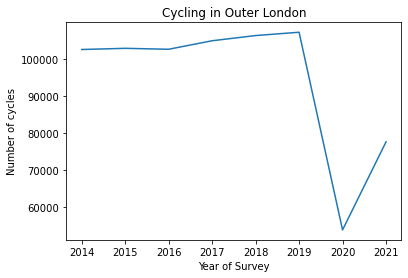

In [22]:
# Create the line chart
plt.plot(df['Survey_wave_(year)'], df['Total_cycles'])

# Adding the aesthetics
plt.title("Cycling in Outer London")
plt.xlabel('Year of Survey')
plt.ylabel('Number of cycles')

# Show the plot
plt.show()

## Does the time of the day matter?

In [23]:
# Aggregate by time of day

df= central_london.groupby(['Period'], as_index=False)['Total_cycles'].sum()
df.sort_values('Total_cycles', inplace = True)

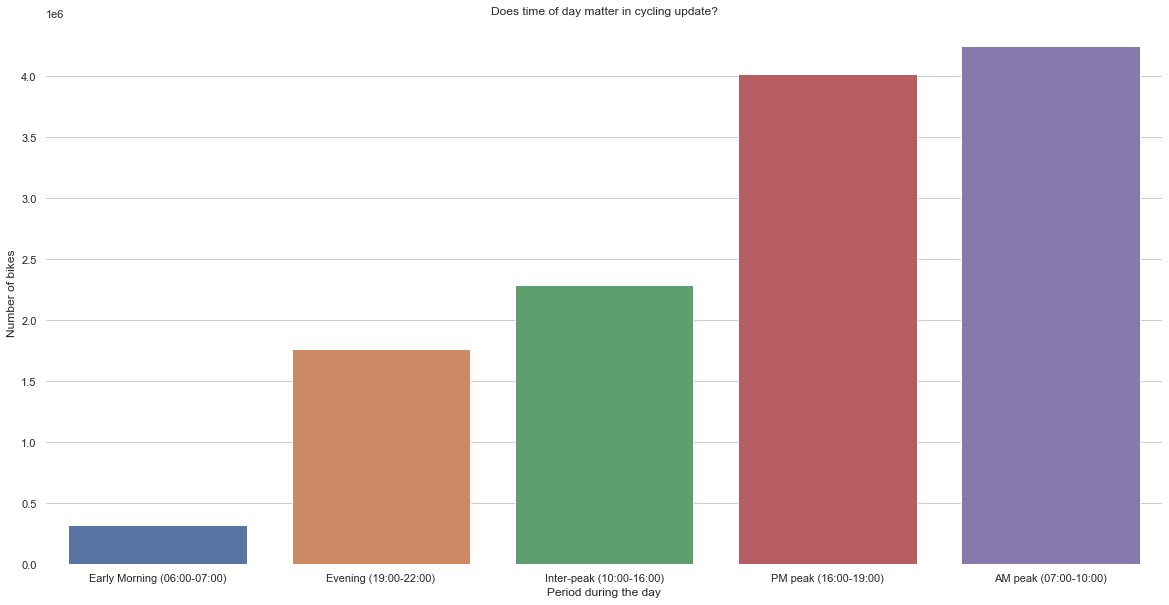

In [24]:
# Chart to view time of day with highest cycling count
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialise matplotlib fiture
f, g = plt.subplots(figsize = (20,10))

g=sns.barplot(x = df['Period'], y = df['Total_cycles'])

# Add legend and add title etc
g.set(ylabel = "Number of bikes",
     xlabel = "Period during the day")
g.set_title('Does time of day matter in cycling update?')
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()

# Peak data shows not all return journeys. Why? Safety? Lights? Weather? Something else?

## Do Seasons matter?

In [25]:
# Aggregate data by Weather
df= central_london.groupby(['season'], as_index=False)['Total_cycles'].sum()
df

,season,Total_cycles
0,Autumn,3405461.0
1,Spring,3154323.0
2,Summer,3285146.0
3,Winter,2780789.0


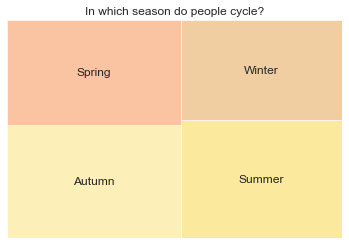

In [26]:
# Plotting a treemap
# Colour Palette
colors=['#fae588','#f79d65','#f9dc5c','#e8ac65','#e76f51','#ef233c','#b7094c']

# Set Plot Style
sns.set_style(style="whitegrid") 

# Setting the variable
sizes= df["Total_cycles"].values
label=df["season"]

# Setting the styles
squarify.plot(sizes=sizes, label=label, alpha=0.6,color=colors).set(title='In which season do people cycle?')
plt.axis('off')
plt.show()

# Need to ask Kevin to prettify
# Explore waffle charts
# Here seems there is much less seasonal. 
# So people not sensitive to seasons.
# Other two London data biased as data was collected in only certain seasons

## Does Weather Matter?

In [27]:
# Aggregate data by Weather
df= central_london.groupby(['Weather'], as_index=False)['Total_cycles'].sum()
df
# Clearly a big factor. But how does this compare to other cities? 
# For within each condition what % of London is on bike versus their peers in other cities?

,Weather,Total_cycles
0,Damp,26115.0
1,Dangerous_Conditions,49254.0
2,Good,11223264.0
3,Rain,1141192.0
4,Unknown,185894.0


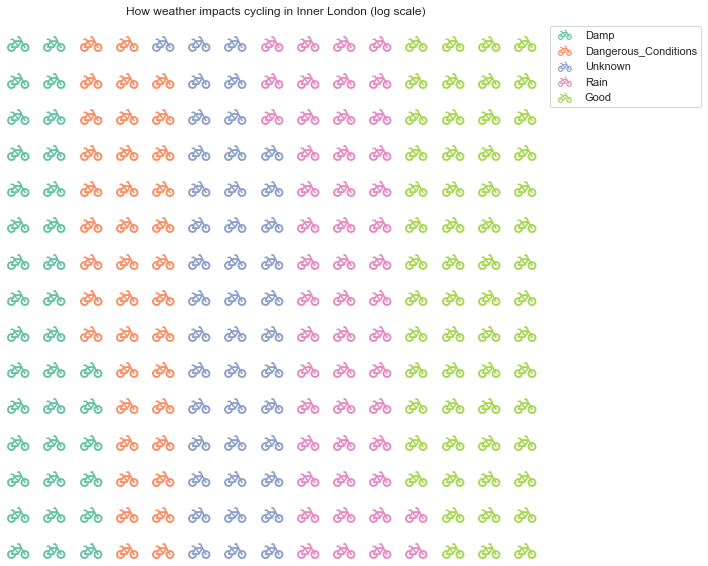

In [28]:
# Plot Waffle Chart
# Change to log scale
data = {'Damp': math.log(26115), 'Dangerous_Conditions': math.log(49254), 'Unknown': math.log(185894), 'Rain': math.log(1141192), 
        'Good': math.log(11223264)}
fig = plt.figure(FigureClass = Waffle, rows = 15, columns = 15, values = data, 
                 title = {'label': 'How weather impacts cycling in Inner London (log scale)'}, 
                 legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)}, 
                 figsize = (10,15), icons='bicycle', icon_size=18, icon_legend=True)


# Ask Kevin to prettify and explore doughnut, stacked percentage bar etc

In [29]:
# More Variables & Merge Data Set.